In [1]:
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# surpress warnings
import warnings
warnings.filterwarnings('ignore')


# Question 1

In the soluion of the assignment 1, we have wrote several helper methods. These are:
- get_files: returns a list of the data files in a data folder
- load_dict: loads a data file
- load_df: loads all of the files in a data folder to a dataframe
- get_song_dfs: gets a list of dataframes. Each dataframe represents a song


In [2]:
def get_files(folder):
    directory = "data/%s/" % folder
    return glob.glob(directory + "*.json")

def load_dict(file):
    d = None
    with open(file.replace("\\", "/")) as file:
        d = json.load(file)
    return d

def load_df(folder):

    files = get_files(folder)
    get_date = lambda file_name: file_name[len(folder) + 6:-15]

    if folder in ["youtube_top100", "radio3fm_megahit", "radio538_alarmschijf"]:

        keys = ['viewCount',
                'likeCount',
                'dislikeCount',
                'commentCount',
                #'favoriteCount'
                ]
                
        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for song_data in year_data:
                row = [get_date(year_file), song_data['snippet']['title']]
                row.extend([song_data['statistics'][key] for key in keys])
                df.append(row)

        columns = ['date', 'songName']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)

        for column in ['likeCount', 'dislikeCount']:
            df[column] = df[column].astype('int')
        df['likeDislikeDiff']  = df['likeCount'] - df['dislikeCount']
        df['likeDislikeTotal'] = df['likeCount'] + df['dislikeCount']

        df.index = pd.to_datetime(df['date'], format='%Y%m%d')
            
        return df
    if folder == "spotify_top100":        

        # missing artist name

        keys = ['name',
                'popularity']

        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for track_data in year_data['tracks']['items']:
                row = [get_date(year_file)]
                row.extend(track_data['track'][key] for key in keys)
                df.append(row)
        
        columns = ['date']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)
        
        df.index = pd.to_datetime(df['date'], format='%Y%m%d')

        return df
    else:
        raise AssertionError("Function not implemented for the folder \"%s\"" % folder)

def get_song_dfs(df, n=None, seed=37):
    """Get a list of dataframes. Each dataframe represents one song

    Create the dataframe with the song name and then interpolate to fill
    empty dates

    Args:
        df (DataFrame): Original dataframe. Should be created from Youtube format
        n (int): Number of song dfs to create and return. Default value in None,
            all the possible songs are used to create song dfs when n is None.
    """
    np.random.seed(seed)

    songs = df['songName'].unique()
    if n:
        songs = np.random.choice(songs, n)
    song_dfs = []
    for song_name in songs:
        song_df = df[df['songName'] == song_name]
        song_df = song_df.resample('D').asfreq()
        song_df = song_df.interpolate()
        song_dfs.append(song_df)
    return song_dfs

Helper methods are used to load data from Youtube file:

In [3]:
youtube_df = load_df("youtube_top100")
radio_dfs = (load_df("radio3fm_megahit"), load_df("radio538_alarmschijf"))
youtube_df

,date,songName,viewCount,likeCount,dislikeCount,commentCount,likeDislikeDiff,likeDislikeTotal
date,,,,,,,,
2015-11-09,20151109,Adele - Hello,297130779,4093202,101335,291458,3991867,4194537
2015-11-09,20151109,Justin Bieber - Sorry (Dance Video),92743480,1355977,71243,104720,1284734,1427220
2015-11-09,20151109,Drake - Hotline Bling,57075104,672355,60531,72120,611824,732886
2015-11-09,20151109,Justin Bieber - What Do You Mean?,276365510,2310400,254413,189319,2055987,2564813
2015-11-09,20151109,Shawn Mendes - Stitches (Official Video),72148555,906781,14618,57624,892163,921399
...,...,...,...,...,...,...,...,...
2016-11-28,20161128,Flo Rida - My House [Official Video],177568317,965907,37839,47163,928068,1003746
2016-11-28,20161128,Drake - Right Hand Girl dance vine,700870,7521,256,457,7265,7777
2016-11-28,20161128,Rihanna - Bitch Better Have My Money (Explicit),100217083,1590438,192198,128521,1398240,1782636


Then dataframes are created for 10 songs and difference of likes and dislikes are calculated in each date. Then this difference is plotted for each song.

<Figure size 1152x576 with 0 Axes>

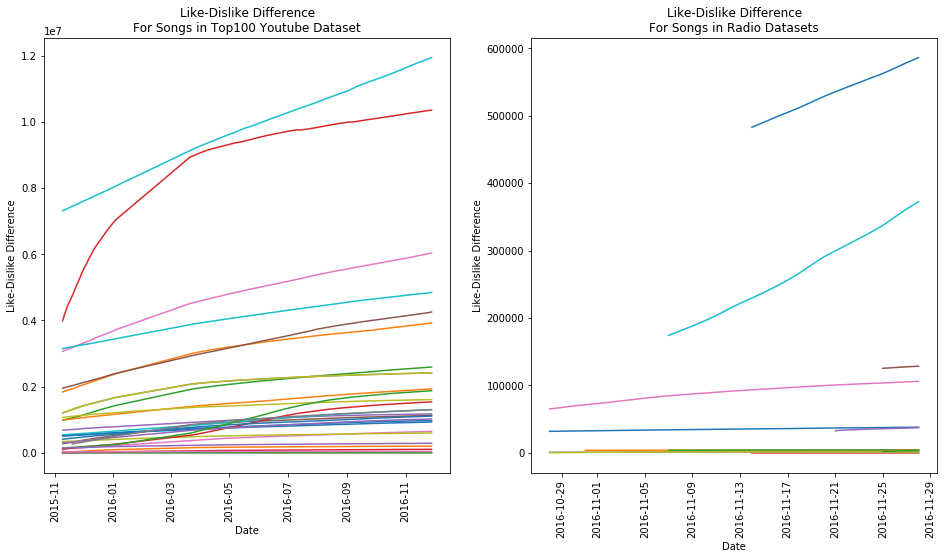

In [4]:
plt.figure(figsize = (16,8))

fig, axs = plt.subplots(1,2, figsize=(16,8))

# plot youtube data
seed = 15
song_dfs = get_song_dfs(youtube_df, 30, seed)
for song_df in song_dfs:
    axs[0].plot(song_df.index,
        song_df['likeDislikeDiff']
        )

# plot radio data
for radio_df in radio_dfs:
    song_dfs = get_song_dfs(radio_df)
    for song_df in song_dfs:
        axs[1].plot(song_df.index,
            song_df['likeDislikeDiff']
            )

axs[0].title.set_text("Like-Dislike Difference\nFor Songs in Top100 Youtube Dataset")
axs[1].title.set_text("Like-Dislike Difference\nFor Songs in Radio Datasets")

for ax in axs:
    ax.set_xlabel("Date")
    ax.set_ylabel("Like-Dislike Difference")
    ax.tick_params('x', labelrotation=90)

plt.show()

Then another plot is generated by normalizing the songs by dividing the like-dislike difference series by the first day of the series, making each song’s series start from 1.

<Figure size 1152x576 with 0 Axes>

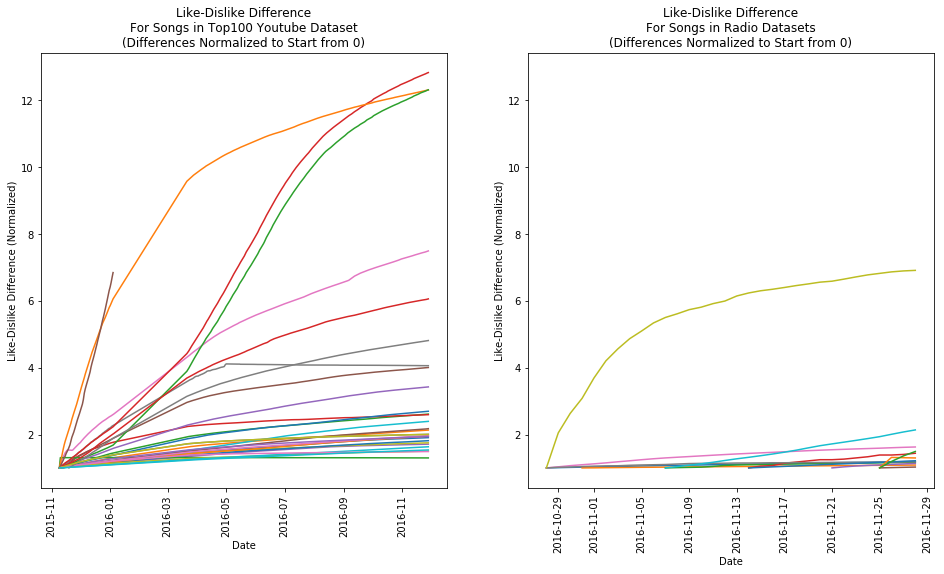

In [5]:
plt.figure(figsize = (16,8))

fig, axs = plt.subplots(1,2, figsize=(16,8))

# plot youtube data
song_dfs = get_song_dfs(youtube_df, 30, seed)
for song_df in song_dfs:
    axs[0].plot(song_df.index,
        song_df['likeDislikeDiff'] / song_df['likeDislikeDiff'][0]
        )

# plot radio data
for radio_df in radio_dfs:
    song_dfs = get_song_dfs(radio_df)
    for song_df in song_dfs:
        axs[1].plot(song_df.index,
            song_df['likeDislikeDiff'] / song_df['likeDislikeDiff'][0]
            )

axs[0].title.set_text("Like-Dislike Difference\nFor Songs in Top100 Youtube Dataset\n(Differences Normalized to Start from 0)")
axs[1].title.set_text("Like-Dislike Difference\nFor Songs in Radio Datasets\n(Differences Normalized to Start from 0)")

for ax in axs:
    ax.set_xlabel("Date")
    ax.set_ylabel("Like-Dislike Difference (Normalized)")
    ax.tick_params('x', labelrotation=90)

axs[1].set_ylim(axs[0].get_ylim())

plt.show()